In [1]:
%pylab inline
plt.style.use("ggplot")
from qnet.algebra.circuit_algebra import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import qnet.circuit_components.pseudo_nand_latch_cc as pnl


In [9]:
alpha, S, R = symbols("alpha, S, R")

L = pnl.PseudoNANDLatch("L").coherent_input(alpha-S, 0, 0, alpha-R, 0, 0).toSLH().expand()


In [10]:
L

SLH(Matrix([[sqrt(2)/2, 0, sqrt(2)*exp(I*phi)*sin(theta)/2, 0, -sqrt(2)*exp(I*phi)*cos(theta)/2, 0], [sqrt(2)/2, 0, -sqrt(2)*exp(I*phi)*sin(theta)/2, 0, sqrt(2)*exp(I*phi)*cos(theta)/2, 0], [0, 0, cos(theta), 0, sin(theta), 0], [0, -sqrt(2)*exp(I*phi)*cos(theta)/2, 0, sqrt(2)/2, 0, sqrt(2)*exp(I*phi)*sin(theta)/2], [0, sqrt(2)*exp(I*phi)*cos(theta)/2, 0, sqrt(2)/2, 0, -sqrt(2)*exp(I*phi)*sin(theta)/2], [0, sin(theta), 0, 0, 0, cos(theta)]]), Matrix([[OperatorPlus(ScalarTimesOperator(-sqrt(2)*beta*exp(I*phi)*cos(theta)/2 + sqrt(2)*(-S + alpha)/2, IdentityOperator), ScalarTimesOperator(sqrt(2)*sqrt(kappa)*exp(I*phi)*sin(theta)/2, Destroy(LocalSpace('L.NAND2.K', ''))))], [OperatorPlus(ScalarTimesOperator(sqrt(2)*beta*exp(I*phi)*cos(theta)/2 + sqrt(2)*(-S + alpha)/2, IdentityOperator), ScalarTimesOperator(sqrt(kappa), Destroy(LocalSpace('L.NAND1.K', ''))), ScalarTimesOperator(-sqrt(2)*sqrt(kappa)*exp(I*phi)*sin(theta)/2, Destroy(LocalSpace('L.NAND2.K', ''))))], [OperatorPlus(ScalarTimesOpe

In [12]:
Delta, R, S, alpha, beta, chi, kappa, phi, theta = sorted(L.all_symbols(), key=str)
sorted(L.all_symbols(), key=str)

[Delta, R, S, alpha, beta, chi, kappa, phi, theta]

In [14]:
# numerical values for simulation

logic_1 = 22.6274                              # logical 'one' amplitude

nvals = {
                  alpha: logic_1,
                  beta: -34.289-11.909j,     # bias input for pseudo-nands
                  kappa: 25.,                # Kerr-Cavity mirror couplings
                  Delta: 50.,                # Kerr-Cavity Detuning
                  chi : -50./60.,            # Kerr-Non-Linear coupling coefficient
                  theta: 0.891,              # pseudo-nand beamsplitter mixing angle
                  phi: 2.546,                # pseudo-nand corrective phase
    }

Ln = L.substitute(nvals).expand().simplify_scalar()
Ln

SLH(Matrix([[sqrt(2)/2, 0, 0.388850385456327*sqrt(2)*exp(2.546*I), 0, -0.314317320124847*sqrt(2)*exp(2.546*I), 0], [sqrt(2)/2, 0, -0.388850385456327*sqrt(2)*exp(2.546*I), 0, 0.314317320124847*sqrt(2)*exp(2.546*I), 0], [0, 0, 0.628634640249695, 0, 0.777700770912654, 0], [0, -0.314317320124847*sqrt(2)*exp(2.546*I), 0, sqrt(2)/2, 0, 0.388850385456327*sqrt(2)*exp(2.546*I)], [0, 0.314317320124847*sqrt(2)*exp(2.546*I), 0, sqrt(2)/2, 0, -0.388850385456327*sqrt(2)*exp(2.546*I)], [0, 0.777700770912654, 0, 0, 0, 0.628634640249695]]), Matrix([[OperatorPlus(ScalarTimesOperator(sqrt(2)*(-S + 22.6274 + 2*(10.7776265897609 + 3.74320496536681*I)*exp(2.546*I))/2, IdentityOperator), ScalarTimesOperator(1.94425192728164*sqrt(2)*exp(2.546*I), Destroy(LocalSpace('L.NAND2.K', ''))))], [OperatorPlus(ScalarTimesOperator(sqrt(2)*(-S + 22.6274 - 2*(10.7776265897609 + 3.74320496536681*I)*exp(2.546*I))/2, IdentityOperator), ScalarTimesOperator(5.00000000000000, Destroy(LocalSpace('L.NAND1.K', ''))), ScalarTimesOp

In [15]:
HOLD = {S: 0, R:0}
SET = {S: logic_1, R:0}
RESET = {S: 0, R:logic_1}

In [37]:
tlist5 = linspace(0, .5, 51)
tlist15 = linspace(0, 1.5, 151)
tlist1 = linspace(0, 1., 101)

HLHOLD = Ln.substitute(HOLD).HL_to_qutip()
HLSET = Ln.substitute(SET).HL_to_qutip()
HLRESET = Ln.substitute(RESET).HL_to_qutip()
import qutip
psi0 = qutip.tensor(qutip.basis(Ln.space.local_factors()[0].dimension, 0), qutip.basis(Ln.space.local_factors()[1].dimension, 0))

print("Solving...")
res1 = qutip.mcsolve(HLSET[0], psi0, tlist1, HLSET[1], [], ntraj=1)
print("next...")
res2 = qutip.mcsolve(HLHOLD[0], res1.states[-1][-1], tlist1, HLHOLD[1], [], ntraj=1)
print("next...")
res3 = qutip.mcsolve(HLRESET[0], res2.states[-1][-1], tlist1, HLRESET[1], [], ntraj=1)
print("next...")
res4 = qutip.mcsolve(HLHOLD[0], res3.states[-1][-1], tlist1, HLHOLD[1], [], ntraj=1)

Solving...
Total run time:  48.56s
next...
Total run time:  61.70s
next...
Total run time:  49.50s
next...
Total run time:  60.63s


In [38]:
a1, a2 = [Destroy(sj) for sj in Ln.space.local_factors()]
nq1, nq2 = [(aj.dag()*aj).to_qutip(full_space=Ln.space) for aj in [a1, a2]]

In [39]:
states = np.hstack([res1.states[0], res2.states[0], res3.states[0], res4.states[0]])

In [40]:
obs = qutip.expect([nq1, nq2], states)

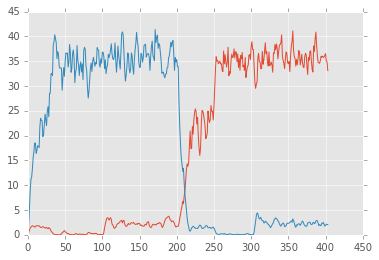

In [41]:
plot(obs[0])
plot(obs[1])